In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.dates as mdates  #Importing module for date formatting
import matplotlib.ticker as ticker  # Importing ticker for customizing colorbar ticks
from scipy.ndimage import gaussian_filter
import seaborn as sns
import glob
from datetime import datetime
from metpy.calc import mixing_ratio_from_specific_humidity
from metpy.calc import virtual_potential_temperature
from scipy import signal

# Processing `wrfout_wind` to get virtual `potential temperature data`

In [4]:
# Specify the path to the variables
path_to_variables = sorted(glob.glob("/glade/campaign/ral/wsap/tjuliano/comble/coupled_meso_micro/RESTART_*/compressed/wrfout_wind_d02_2020-03-*"))

# Open the datasets
datasets = [xr.open_dataset(i) for i in path_to_variables]

# Generate the time dimension
time_dim = pd.date_range(start="2020-03-13", periods=len(datasets), freq='5T')

# Initialize lists to hold the variables' datasets
q2_datasets = [] # specific humidity at 2m
psfc_datasets = [] # surface pressure
t2_datasets = [] # temperature at 2m

# Extract variables and add the time dimension
for i, ds in enumerate(datasets):
    q2 = ds['Q2'].assign_coords(time=time_dim[i]).expand_dims("time")
    psfc = ds['PSFC'].assign_coords(time=time_dim[i]).expand_dims("time")
    t2 = ds['T2'].assign_coords(time=time_dim[i]).expand_dims("time")
    
    q2_datasets.append(q2)
    psfc_datasets.append(psfc)
    t2_datasets.append(t2)

# Concatenate the variables along the time dimension
combined_q2 = xr.concat(q2_datasets, dim='time')
combined_psfc = xr.concat(psfc_datasets, dim='time')
combined_t2 = xr.concat(t2_datasets, dim='time')

# Combine into a single dataset
combined_dataset = xr.merge([combined_q2, combined_psfc, combined_t2])

# Save the combined dataset to a new netCDF file
combined_dataset.to_netcdf("Q2_PSFC_T2_wrfout_2020_03_combined.nc")

print("Done saving 'Q2', 'PSFC', and 'T2' data to file!!!")


Done saving 'Q2', 'PSFC', and 'T2' data to file!!!


## Extracted variables needed to calculate for _virtual potential temperature_

In [6]:
data = xr.open_dataset('Q2_PSFC_T2_wrfout_2020_03_combined.nc').squeeze('Time')
data = data.sel(time=slice("2020-03-13T04:00:00.000000000", "2020-03-14T00:00:00.000000000"))
data_andenes = data.isel(south_north=282, west_east=1651)
data_andenes

<xarray.Dataset>
Dimensions:  (time: 241)
Coordinates:
    XLAT     float32 ...
    XLONG    float32 ...
  * time     (time) datetime64[ns] 2020-03-13T04:00:00 ... 2020-03-14
Data variables:
    Q2       (time) float32 ...
    PSFC     (time) float32 ...
    T2       (time) float32 ...
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  QV at 2 M
    units:        kg kg-1
    stagger:

In [7]:
time = data_andenes['time']
specific_humidity = data_andenes['Q2']
pressure = data_andenes['PSFC']
temperature = data_andenes['T2']

In [9]:
data = { 'time[min]': time, 'temperature[K]': temperature *units.kelvin, 
        'pressure[Pa]': pressure * units('Pa'), r'specific humidity[kg/kg]': specific_humidity*units('kg/kg')}

df = pd.DataFrame(data=data)
df

,time[min],temperature[K],pressure[Pa],specific humidity[kg/kg]
0,2020-03-13 04:00:00,267.333191,99078.570312,0.002027
1,2020-03-13 04:05:00,267.446716,99134.531250,0.001869
2,2020-03-13 04:10:00,266.893005,99174.250000,0.001962
3,2020-03-13 04:15:00,267.142426,99152.218750,0.001836
4,2020-03-13 04:20:00,267.393127,99197.992188,0.001641
...,...,...,...,...
236,2020-03-13 23:40:00,266.663116,100558.789062,0.001452
237,2020-03-13 23:45:00,267.143311,100555.031250,0.001458
238,2020-03-13 23:50:00,267.670319,100579.867188,0.001850
239,2020-03-13 23:55:00,267.622620,100600.453125,0.001667


In [11]:
# calculating specific humidity
mixing_ratio = mixing_ratio_from_specific_humidity(df['specific humidity[kg/kg]'].values).to('kg/kg')
df['mixing_ratio[g/kg]'] = mixing_ratio

In [15]:
pressure = df['pressure[Pa]'].values* units('Pa')
temperature = df['temperature[K]'].values* units.kelvin
mixing_ratio = df['mixing_ratio[g/kg]'].values * units('kg/kg')
# Calculate virtual potential temperature
df['virtual_potential_temperature[K]'] = virtual_potential_temperature(
    pressure, temperature, mixing_ratio)

In [16]:
df

,time[min],temperature[K],pressure[Pa],specific humidity[kg/kg],mixing_ratio[g/kg],virtual_potential_temperature[K]
0,2020-03-13 04:00:00,267.333191,99078.570312,0.002027,0.002031,268.371399
1,2020-03-13 04:05:00,267.446716,99134.531250,0.001869,0.001872,268.416321
2,2020-03-13 04:10:00,266.893005,99174.250000,0.001962,0.001966,267.845184
3,2020-03-13 04:15:00,267.142426,99152.218750,0.001836,0.001840,268.091919
4,2020-03-13 04:20:00,267.393127,99197.992188,0.001641,0.001644,268.276337
...,...,...,...,...,...,...
236,2020-03-13 23:40:00,266.663116,100558.789062,0.001452,0.001454,266.473877
237,2020-03-13 23:45:00,267.143311,100555.031250,0.001458,0.001460,266.957520
238,2020-03-13 23:50:00,267.670319,100579.867188,0.001850,0.001853,267.528992
239,2020-03-13 23:55:00,267.622620,100600.453125,0.001667,0.001670,267.435913


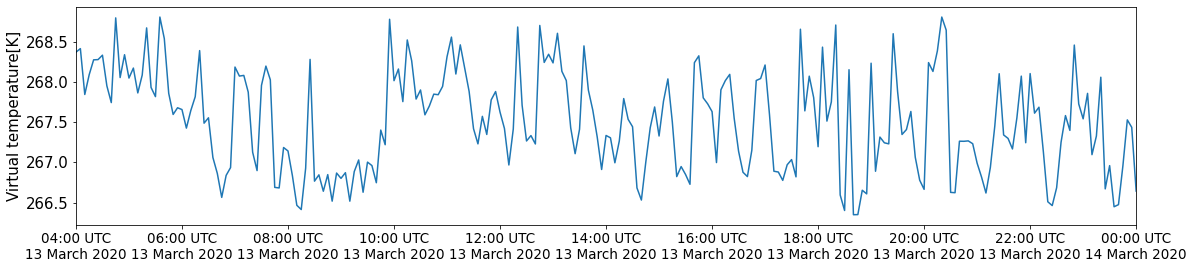

In [18]:
fig, ax = plt.subplots(figsize=(19, 4))
ax.plot(df['time[min]'], df['virtual_potential_temperature[K]'])


    # Custom datetime format
custom_date_format = "%H:%M UTC\n%d %B %Y"  # Format example: 04:00 UTC\n13 March 2020

# Formatting the x-axis with datetime information
ax.xaxis.set_major_formatter(mdates.DateFormatter(custom_date_format))

# Setting the xlim to cover the full range of dates
ax.set_xlim([df['time[min]'].min(), df['time[min]'].max()])
ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel('Virtual temperature[K]', fontsize=15)

# Custom tick positions and labels for the x-axis
num_ticks = 11  # Number of tick labels
tick_positions = np.linspace(0, len(df['time[min]']) - 1, num_ticks, dtype=int)
tick_labels = [df['time[min]'].iloc[pos].strftime(custom_date_format) for pos in tick_positions]
ax.set_xticks(df['time[min]'].iloc[tick_positions])
ax.set_xticklabels(tick_labels, fontsize=13.5, rotation=0);  # Adjust fontsize and rotation as needed


# Next step
#### Remove the linear fit in the data by Detrending 
* scipy detrend function

In [21]:
original_data = df['virtual_potential_temperature[K]']
# Detrend the data by subtracting a linear fit
detrended_data = signal.detrend(original_data)

df['detrend_virtual_potential_temperature[K]'] = detrended_data

df

,time[min],temperature[K],pressure[Pa],specific humidity[kg/kg],mixing_ratio[g/kg],virtual_potential_temperature[K],detrend_virtual_potential_temperature[K]
0,2020-03-13 04:00:00,267.333191,99078.570312,0.002027,0.002031,268.371399,0.610321
1,2020-03-13 04:05:00,267.446716,99134.531250,0.001869,0.001872,268.416321,0.657288
2,2020-03-13 04:10:00,266.893005,99174.250000,0.001962,0.001966,267.845184,0.088165
3,2020-03-13 04:15:00,267.142426,99152.218750,0.001836,0.001840,268.091919,0.336945
4,2020-03-13 04:20:00,267.393127,99197.992188,0.001641,0.001644,268.276337,0.523376
...,...,...,...,...,...,...,...
236,2020-03-13 23:40:00,266.663116,100558.789062,0.001452,0.001454,266.473877,-0.808838
237,2020-03-13 23:45:00,267.143311,100555.031250,0.001458,0.001460,266.957520,-0.323151
238,2020-03-13 23:50:00,267.670319,100579.867188,0.001850,0.001853,267.528992,0.250336
239,2020-03-13 23:55:00,267.622620,100600.453125,0.001667,0.001670,267.435913,0.159302


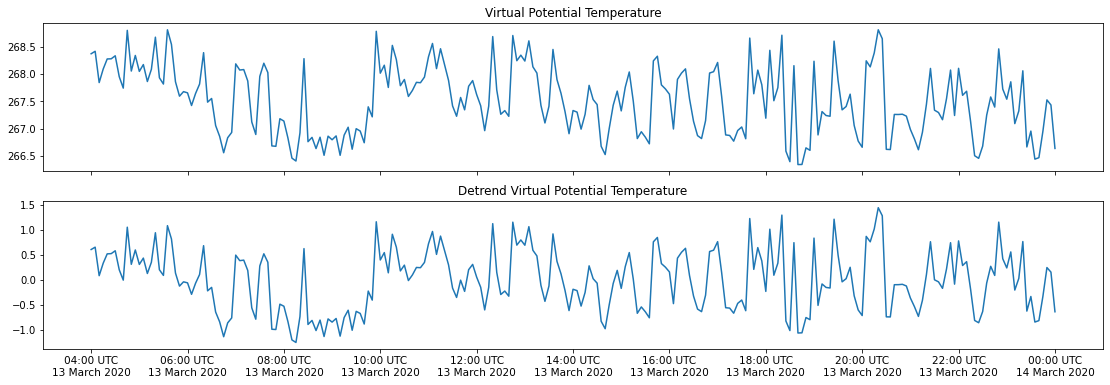

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(19, 6), sharex=True)
ax = ax.flatten()
ax[0].plot(df['time[min]'], df['virtual_potential_temperature[K]'])
ax[1].plot(df['time[min]'], df['detrend_virtual_potential_temperature[K]'])
ax[1].tick_params(axis='y', labelsize=10)
ax[0].tick_params(axis='y', labelsize=10)
ax[1].set_title('Detrend Virtual Potential Temperature')
ax[0].set_title('Virtual Potential Temperature')


    # Custom datetime format
custom_date_format = "%H:%M UTC\n%d %B %Y"  # Format example: 04:00 UTC\n13 March 2020

# Formatting the x-axis with datetime information
ax[1].xaxis.set_major_formatter(mdates.DateFormatter(custom_date_format))


# Custom tick positions and labels for the x-axis
num_ticks = 11 # Number of tick labels
tick_positions = np.linspace(0, len(df['time[min]']) - 1, num_ticks, dtype=int)
tick_labels = [df['time[min]'].iloc[pos].strftime(custom_date_format) for pos in tick_positions]
ax[1].set_xticks(df['time[min]'].iloc[tick_positions])
ax[1].set_xticklabels(tick_labels, fontsize=10.5, rotation=0);  # Adjust fontsize and rotation as needed
# fig.savefig("virtual-potential-temp.jpg", dpi=500, bbox_inches='tight')

# 6-hour mean to calculate the virtual potential temperature anomaly, which is a method of normalizing the data to see how much each point deviates from a short-term average.

In [23]:
df.index = pd.to_datetime(df.index)  # Convert the index to a DateTimeIndex
# Calculate the 6-hour rolling mean
df['6h_Rolling_Mean'] = df['virtual_potential_temperature[K]'].rolling(window='6H').mean()
# Calculate the anomaly by subtracting the 6-hour rolling mean from the virtual potential temperature
df['Anomaly_6h_Mean'] = df['virtual_potential_temperature[K]'] - df['6h_Rolling_Mean']
df['Anomaly_6h_Mean']

1970-01-01 00:00:00.000000000    0.000000
1970-01-01 00:00:00.000000001    0.022461
1970-01-01 00:00:00.000000002   -0.365784
1970-01-01 00:00:00.000000003   -0.089287
1970-01-01 00:00:00.000000004    0.076105
                                   ...   
1970-01-01 00:00:00.000000236   -1.050320
1970-01-01 00:00:00.000000237   -0.564296
1970-01-01 00:00:00.000000238    0.007146
1970-01-01 00:00:00.000000239   -0.085575
1970-01-01 00:00:00.000000240   -0.875141
Name: Anomaly_6h_Mean, Length: 241, dtype: float64

In [24]:
# latex_part = r"$\theta_v - \overline{\theta_{v,6h}}\,[K]$"
#             anomaly_part = "Temp. Anomaly"
#             ax[i].set_ylabel(f"{anomaly_part}\n{latex_part}", fontsize=15, c='red')

In [25]:
# fig, ax = plt.subplots(figsize=(19, 4))
# ax.plot(df['time[min]'], df['Anomaly_6h_Mean'])

#     # Custom datetime format
# custom_date_format = "%H:%M UTC\n%d %B %Y"  # Format example: 04:00 UTC\n13 March 2020

# # Formatting the x-axis with datetime information
# ax.xaxis.set_major_formatter(mdates.DateFormatter(custom_date_format))

# # Setting the xlim to cover the full range of dates
# ax.set_xlim([df['time[min]'].min(), df['time[min]'].max()])
# ax.tick_params(axis='y', labelsize=15)
# ax.set_ylabel('Virtual temperature[K]', fontsize=15)

# # Custom tick positions and labels for the x-axis
# num_ticks = 11  # Number of tick labels
# tick_positions = np.linspace(0, len(df['time[min]']) - 1, num_ticks, dtype=int)
# tick_labels = [df['time[min]'].iloc[pos].strftime(custom_date_format) for pos in tick_positions]
# ax.set_xticks(df['time[min]'].iloc[tick_positions])
# ax.set_xticklabels(tick_labels, fontsize=13.5, rotation=0);  # Adjust fontsize and rotation as needed

In [26]:
# Detrend the data
detrend = df['detrend_virtual_potential_temperature[K]']

# Calculate the anomaly by subtracting the mean of the detrended data from the detrended virtual potential temperature
df['Anomaly_Detrended'] = detrend - detrend.mean()
df['Anomaly_Detrended']

1970-01-01 00:00:00.000000000    0.610312
1970-01-01 00:00:00.000000001    0.657279
1970-01-01 00:00:00.000000002    0.088156
1970-01-01 00:00:00.000000003    0.336936
1970-01-01 00:00:00.000000004    0.523367
                                   ...   
1970-01-01 00:00:00.000000236   -0.808847
1970-01-01 00:00:00.000000237   -0.323160
1970-01-01 00:00:00.000000238    0.250327
1970-01-01 00:00:00.000000239    0.159293
1970-01-01 00:00:00.000000240   -0.631906
Name: Anomaly_Detrended, Length: 241, dtype: float32

In [27]:
# fig, ax = plt.subplots(figsize=(19, 4))
# ax.plot(df['time[min]'], df['Anomaly_Detrended'])

#     # Custom datetime format
# custom_date_format = "%H:%M UTC\n%d %B %Y"  # Format example: 04:00 UTC\n13 March 2020

# # Formatting the x-axis with datetime information
# ax.xaxis.set_major_formatter(mdates.DateFormatter(custom_date_format))

# # Setting the xlim to cover the full range of dates
# ax.set_xlim([df['time[min]'].min(), df['time[min]'].max()])
# ax.tick_params(axis='y', labelsize=15)
# ax.set_ylabel('Virtual temperature[K]', fontsize=15)

# # Custom tick positions and labels for the x-axis
# num_ticks = 11  # Number of tick labels
# tick_positions = np.linspace(0, len(df['time[min]']) - 1, num_ticks, dtype=int)
# tick_labels = [df['time[min]'].iloc[pos].strftime(custom_date_format) for pos in tick_positions]
# ax.set_xticks(df['time[min]'].iloc[tick_positions])
# ax.set_xticklabels(tick_labels, fontsize=13.5, rotation=0);  # Adjust fontsize and rotation as needed

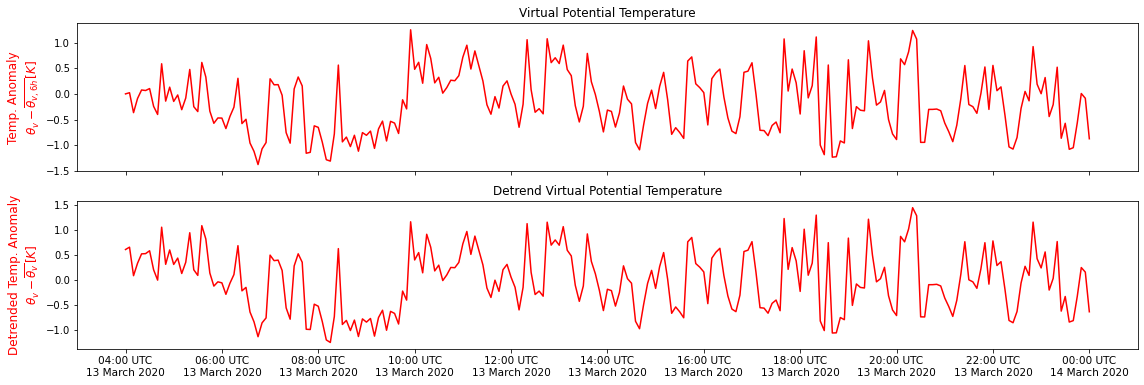

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(19, 6), sharex=True)
ax = ax.flatten()

anomaly_part = "Temp. Anomaly"
latex_part = r"$\theta_v - \overline{\theta_{v,6h}}\,[K]$"
anomaly_part1 = "Detrended Temp. Anomaly"
latex_part1 = r"$\theta_v - \overline{\theta_{v}}\,[K]$"

ax[0].plot(df['time[min]'], df['Anomaly_6h_Mean'], color='red')
ax[0].tick_params(axis='y', labelsize=10)
ax[0].set_title('Virtual Potential Temperature')

ax[0].set_ylabel(f"{anomaly_part}\n{latex_part}", fontsize=12, c='red')



ax[1].plot(df['time[min]'], df['Anomaly_Detrended'], color='red')
ax[1].tick_params(axis='y', labelsize=10)
ax[1].set_title('Detrend Virtual Potential Temperature')
ax[1].set_ylabel(f"{anomaly_part1}\n{latex_part1}", fontsize=12, c='red')



    # Custom datetime format
custom_date_format = "%H:%M UTC\n%d %B %Y"  # Format example: 04:00 UTC\n13 March 2020
# Formatting the x-axis with datetime information
ax[1].xaxis.set_major_formatter(mdates.DateFormatter(custom_date_format))
# Custom tick positions and labels for the x-axis
num_ticks = 11 # Number of tick labels
tick_positions = np.linspace(0, len(df['time[min]']) - 1, num_ticks, dtype=int)
tick_labels = [df['time[min]'].iloc[pos].strftime(custom_date_format) for pos in tick_positions]
ax[1].set_xticks(df['time[min]'].iloc[tick_positions])
ax[1].set_xticklabels(tick_labels, fontsize=10.5, rotation=0);  # Adjust fontsize and rotation as needed
fig.savefig("anomalyvirtual-potential-temp.jpg", dpi=500, bbox_inches='tight')

In [37]:
final_df = df[['time[min]', 'virtual_potential_temperature[K]', 'detrend_virtual_potential_temperature[K]', 'Anomaly_6h_Mean', 'Anomaly_Detrended']]
final_df

,time[min],virtual_potential_temperature[K],detrend_virtual_potential_temperature[K],Anomaly_6h_Mean,Anomaly_Detrended
1970-01-01 00:00:00.000000000,2020-03-13 04:00:00,268.371399,0.610321,0.000000,0.610312
1970-01-01 00:00:00.000000001,2020-03-13 04:05:00,268.416321,0.657288,0.022461,0.657279
1970-01-01 00:00:00.000000002,2020-03-13 04:10:00,267.845184,0.088165,-0.365784,0.088156
1970-01-01 00:00:00.000000003,2020-03-13 04:15:00,268.091919,0.336945,-0.089287,0.336936
1970-01-01 00:00:00.000000004,2020-03-13 04:20:00,268.276337,0.523376,0.076105,0.523367
...,...,...,...,...,...
1970-01-01 00:00:00.000000236,2020-03-13 23:40:00,266.473877,-0.808838,-1.050320,-0.808847
1970-01-01 00:00:00.000000237,2020-03-13 23:45:00,266.957520,-0.323151,-0.564296,-0.323160
1970-01-01 00:00:00.000000238,2020-03-13 23:50:00,267.528992,0.250336,0.007146,0.250327
1970-01-01 00:00:00.000000239,2020-03-13 23:55:00,267.435913,0.159302,-0.085575,0.159293


In [41]:
final_df = final_df.reset_index(drop=True)
final_df

,time[min],virtual_potential_temperature[K],detrend_virtual_potential_temperature[K],Anomaly_6h_Mean,Anomaly_Detrended
0,2020-03-13 04:00:00,268.371399,0.610321,0.000000,0.610312
1,2020-03-13 04:05:00,268.416321,0.657288,0.022461,0.657279
2,2020-03-13 04:10:00,267.845184,0.088165,-0.365784,0.088156
3,2020-03-13 04:15:00,268.091919,0.336945,-0.089287,0.336936
4,2020-03-13 04:20:00,268.276337,0.523376,0.076105,0.523367
...,...,...,...,...,...
236,2020-03-13 23:40:00,266.473877,-0.808838,-1.050320,-0.808847
237,2020-03-13 23:45:00,266.957520,-0.323151,-0.564296,-0.323160
238,2020-03-13 23:50:00,267.528992,0.250336,0.007146,0.250327
239,2020-03-13 23:55:00,267.435913,0.159302,-0.085575,0.159293


In [43]:
vpt = final_df[['time[min]', 'Anomaly_6h_Mean']]
vpt

,time[min],Anomaly_6h_Mean
0,2020-03-13 04:00:00,0.000000
1,2020-03-13 04:05:00,0.022461
2,2020-03-13 04:10:00,-0.365784
3,2020-03-13 04:15:00,-0.089287
4,2020-03-13 04:20:00,0.076105
...,...,...
236,2020-03-13 23:40:00,-1.050320
237,2020-03-13 23:45:00,-0.564296
238,2020-03-13 23:50:00,0.007146
239,2020-03-13 23:55:00,-0.085575


In [44]:
vpt.to_csv('virtual-potential-anomaly.csv', index=False)

In [45]:
pwd

'/glade/work/noteng/masters-research/comble/LES'